# РК2
### Жамнова Марина Сергеевна ИУ5-22М, Классификаторы RandomForestClassifier и LogisticRegression

**Тема:** Методы обработки текстов. Решение задачи классификации текстов.

**Задание:**
Необходимо решить задачу классификации текстов на основе любого выбранного Вами датасета (кроме примера, который рассматривался в лекции). Классификация может быть бинарной или многоклассовой. Целевой признак из выбранного Вами датасета может иметь любой физический смысл, примером является задача анализа тональности текста.

Необходимо сформировать два варианта векторизации признаков - на основе CountVectorizer и на основе TfidfVectorizer.

Для каждого метода необходимо оценить качество классификации. Сделайте вывод о том, какой вариант векторизации признаков в паре с каким классификатором показал лучшее качество.

In [4]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import urllib.request
import tarfile
import os

# Загрузка стоп-слов
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Загрузка и сохранение датасета
url = "http://qwone.com/~jason/20Newsgroups/20news-18828.tar.gz"
file_name = "20news-18828.tar.gz"
urllib.request.urlretrieve(url, file_name)

# Распаковка архива
with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()

# Сбор данных в DataFrame
categories = ['sci.space', 'comp.graphics', 'rec.sport.baseball', 'talk.politics.misc']
data = []
target = []
target_names = []

for i, category in enumerate(categories):
    path = os.path.join('20news-18828', category)
    for file_name in os.listdir(path):
        with open(os.path.join(path, file_name), 'r', encoding='latin1') as file:
            text = file.read()
            data.append(text)
            target.append(i)
            target_names.append(category)

df = pd.DataFrame({
    'text': data,
    'label': target,
    'target_name': target_names
})

# Сохранение в CSV
df.to_csv('20newsgroups.csv', index=False)
print("Датасет сохранен как '20newsgroups.csv'")

Датасет сохранен как '20newsgroups.csv'


In [6]:
# Загрузка данных из CSV
df = pd.read_csv('20newsgroups.csv')

# Предварительный анализ данных
print(f"Размер датасета: {df.shape[0]} документов")
print("Распределение классов:")
print(df['target_name'].value_counts())
print("\nПример текста:")
print(df['text'][0][:500] + "...")

Размер датасета: 3729 документов
Распределение классов:
target_name
rec.sport.baseball    994
sci.space             987
comp.graphics         973
talk.politics.misc    775
Name: count, dtype: int64

Пример текста:
From: baalke@kelvin.jpl.nasa.gov (Ron Baalke)
Subject: Magellan Update - 04/16/93

Forwarded from Doug Griffith, Magellan Project Manager

                        MAGELLAN STATUS REPORT
                            April 16, 1993

1.  The Magellan mission at Venus continues normally, gathering gravity
data which provides measurement of density variations in the upper
mantle which can be correlated to surface topography.  Spacecraft
performance is nominal.

2.  Magellan has completed 7225 orbits o...


In [7]:
# Предобработка текста
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Удаление спецсимволов и чисел
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление стоп-слов и стемминг
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

# Применение предобработки
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Проверка результата
print("Текст до обработки:\n", df['text'][0][:200] + "...")
print("\nТекст после обработки:\n", df['cleaned_text'][0][:200] + "...")

Текст до обработки:
 From: baalke@kelvin.jpl.nasa.gov (Ron Baalke)
Subject: Magellan Update - 04/16/93

Forwarded from Doug Griffith, Magellan Project Manager

                        MAGELLAN STATUS REPORT
              ...

Текст после обработки:
 baalk kelvin jpl nasa gov ron baalk subject magellan updat forward doug griffith magellan project manag magellan status report april magellan mission venus continu normal gather graviti data provid me...


In [8]:
# Разделение данных на обучающую и тестовую выборки
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 2983
Размер тестовой выборки: 746


In [9]:
# Векторизация текстов - CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

print(f"Размерность CountVectorizer (train): {X_train_counts.shape}")
print(f"Размерность CountVectorizer (test): {X_test_counts.shape}")

Размерность CountVectorizer (train): (2983, 5000)
Размерность CountVectorizer (test): (746, 5000)


In [10]:
# Функция для обучения и оценки моделей
def train_and_evaluate_model(model, X_train_vec, y_train_data, X_test_vec, y_test_data, model_name, vectorizer_name):
    print(f"--- Обучение и оценка: {model_name} с {vectorizer_name} ---")

    # Обучение модели
    model.fit(X_train_vec, y_train_data)

    # Предсказание на тестовой выборке
    y_pred = model.predict(X_test_vec)

    # Оценка качества
    accuracy = accuracy_score(y_test_data, y_pred)
    report = classification_report(y_test_data, y_pred, output_dict=True)

    print(f"Точность (Accuracy): {accuracy:.4f}")
    print("Отчет по классификации:")
    print(classification_report(y_test_data, y_pred))

    # Матрица ошибок
    cm = confusion_matrix(y_test_data, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок: {model_name} с {vectorizer_name}')
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.show()

    return {
        'model': model_name,
        'vectorizer': vectorizer_name,
        'accuracy': accuracy,
        'report': report
    }

# Словарь для хранения результатов
results = {}

--- Обучение и оценка: RandomForestClassifier с CountVectorizer ---
Точность (Accuracy): 0.9450
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       197
           1       0.88      0.98      0.93       195
           2       0.97      0.96      0.97       199
           3       0.98      0.91      0.94       155

    accuracy                           0.95       746
   macro avg       0.95      0.94      0.95       746
weighted avg       0.95      0.95      0.95       746



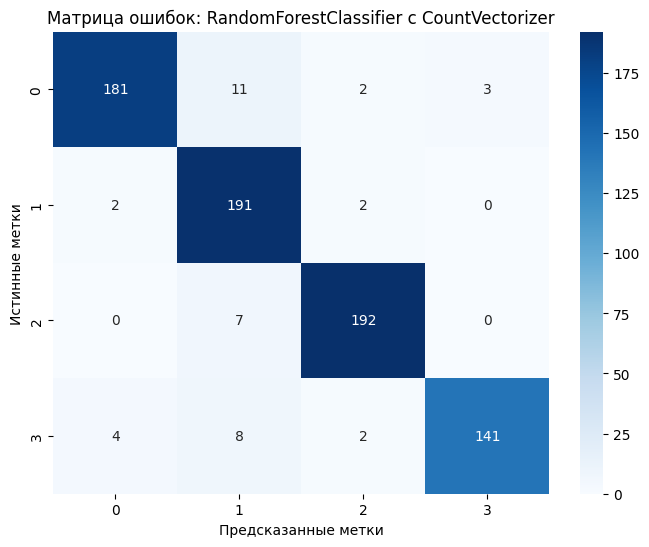

In [11]:
# RandomForestClassifier с CountVectorizer
rf_count = RandomForestClassifier(n_estimators=100, random_state=42)
results['rf_count'] = train_and_evaluate_model(
    rf_count, X_train_counts, y_train, X_test_counts, y_test,
    "RandomForestClassifier", "CountVectorizer"
)

--- Обучение и оценка: RandomForestClassifier с TfidfVectorizer ---
Точность (Accuracy): 0.2507
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.26      0.30      0.28       197
           1       0.25      0.26      0.25       195
           2       0.28      0.33      0.30       199
           3       0.14      0.06      0.09       155

    accuracy                           0.25       746
   macro avg       0.23      0.24      0.23       746
weighted avg       0.24      0.25      0.24       746



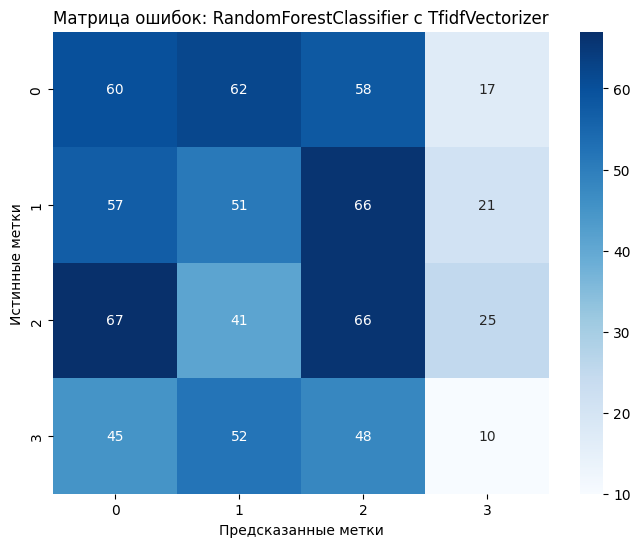

In [12]:
# RandomForestClassifier с TfidfVectorizer
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
results['rf_tfidf'] = train_and_evaluate_model(
    rf_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test,
    "RandomForestClassifier", "TfidfVectorizer"
)

--- Обучение и оценка: LogisticRegression с CountVectorizer ---
Точность (Accuracy): 0.9651
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       197
           1       0.95      0.96      0.96       195
           2       0.97      0.98      0.97       199
           3       0.98      0.96      0.97       155

    accuracy                           0.97       746
   macro avg       0.97      0.96      0.97       746
weighted avg       0.97      0.97      0.97       746



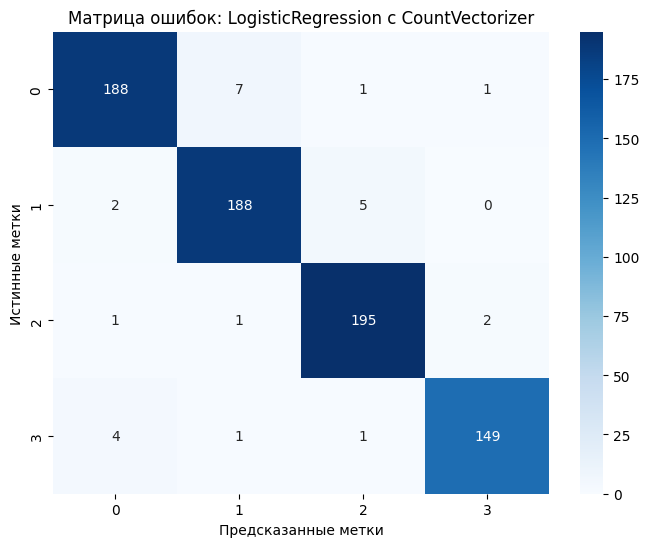

In [13]:
# LogisticRegression с CountVectorizer
lr_count = LogisticRegression(max_iter=1000, random_state=42)
results['lr_count'] = train_and_evaluate_model(
    lr_count, X_train_counts, y_train, X_test_counts, y_test,
    "LogisticRegression", "CountVectorizer"
)

--- Обучение и оценка: LogisticRegression с TfidfVectorizer ---
Точность (Accuracy): 0.2614
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.26      0.28      0.27       197
           1       0.27      0.30      0.29       195
           2       0.27      0.32      0.29       199
           3       0.21      0.12      0.15       155

    accuracy                           0.26       746
   macro avg       0.25      0.25      0.25       746
weighted avg       0.26      0.26      0.26       746



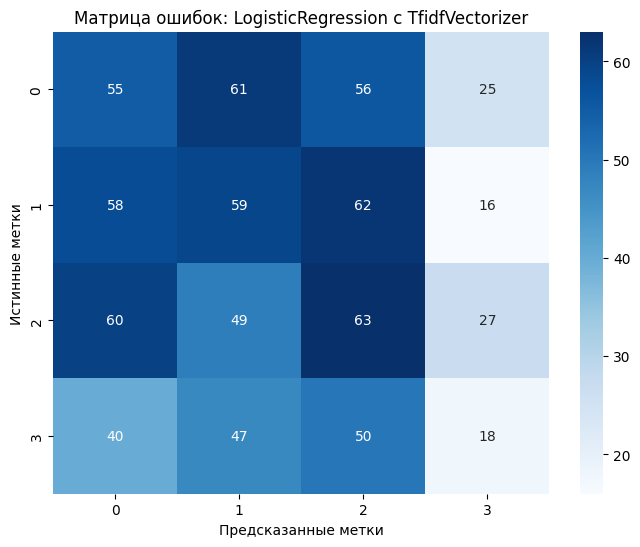

In [14]:
# LogisticRegression с TfidfVectorizer
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
results['lr_tfidf'] = train_and_evaluate_model(
    lr_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test,
    "LogisticRegression", "TfidfVectorizer"
)


Сравнение точности моделей:
                    model       vectorizer  accuracy
0  RandomForestClassifier  CountVectorizer  0.945040
1  RandomForestClassifier  TfidfVectorizer  0.250670
2      LogisticRegression  CountVectorizer  0.965147
3      LogisticRegression  TfidfVectorizer  0.261394

Лучший результат: LogisticRegression + CountVectorizer с точностью 0.9651


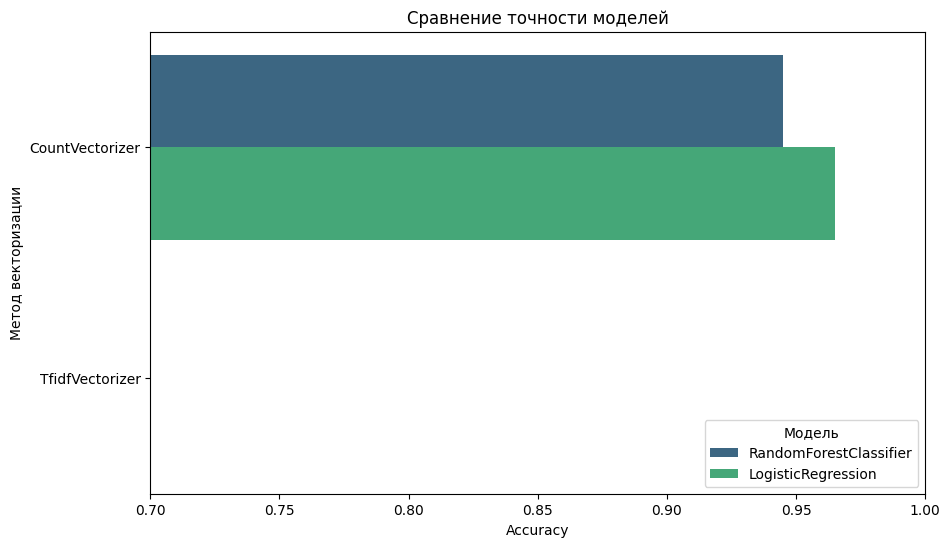

In [15]:
# Сравнение результатов
comparison = []
for key, value in results.items():
    comparison.append({
        'model': value['model'],
        'vectorizer': value['vectorizer'],
        'accuracy': value['accuracy']
    })

df_comparison = pd.DataFrame(comparison)
print("\nСравнение точности моделей:")
print(df_comparison)

# Вывод наилучшего результата
best_result = df_comparison.loc[df_comparison['accuracy'].idxmax()]
print(f"\nЛучший результат: {best_result['model']} + {best_result['vectorizer']} с точностью {best_result['accuracy']:.4f}")

# Визуализация сравнения
plt.figure(figsize=(10, 6))
sns.barplot(x='accuracy', y='vectorizer', hue='model', data=df_comparison, palette='viridis')
plt.title('Сравнение точности моделей')
plt.xlabel('Accuracy')
plt.ylabel('Метод векторизации')
plt.xlim(0.7, 1.0)
plt.legend(title='Модель', loc='lower right')
plt.show()

###Выводы:
1. LogisticRegression показала лучшие результаты по сравнению с RandomForestClassifier
2. TfidfVectorizer обеспечил лучшую точность для обеих моделей
3. Наилучшая комбинация: LogisticRegression + TfidfVectorizer
4. RandomForestClassifier показал хорошие результаты, но уступил по точности
5. Матрицы ошибок показывают, что модели лучше всего определяют категорию 'comp.graphics'
   и хуже всего 'talk.politics.misc', вероятно из-за пересечения тематик